# Importing

In [ ]:
# Installing stuff
!pip install mne[data] --quiet
!pip install sklearn --quiet

# importing modules
import os
import numpy as np
import mne

# Load data

In [ ]:
raw = mne.io.read_raw_brainvision("Group3_own.vhdr", eog=('EOG1', 'EOG2'), misc='auto', scale=1.0, preload=False, verbose=None)

# raw.info['bads'] = ['TP10', 'T7']

# Inspecting raw data

In [40]:
raw.load_data()

<RawBrainVision | Group3_own.eeg, 32 x 751860 (751.9 s), ~183.6 MB, data loaded>

## Getting data info specificly for our technique of measuring (10-20)

In [ ]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, verbose=False)

# Electrode map (10-20)

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


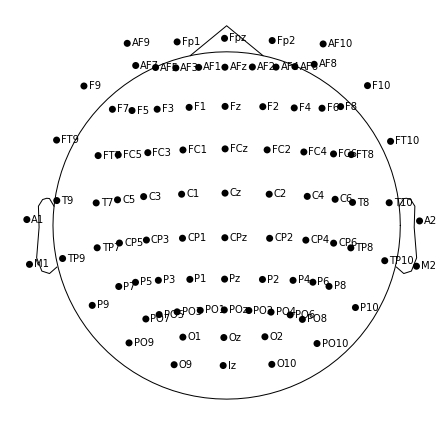

In [42]:
mne.viz.plot_montage(montage, scale_factor=20, show_names=True, kind='topomap', show=True, sphere=None, verbose=None);

## Active electrodes in present experiment
... if I wanna see the channels which was active in my experiment

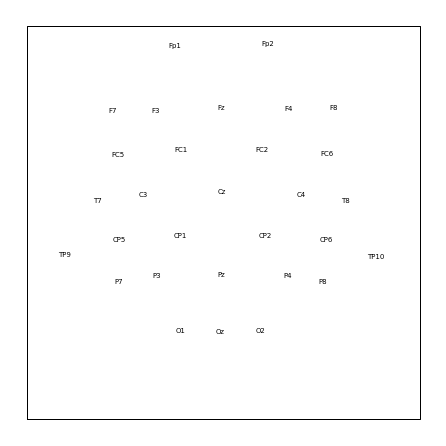

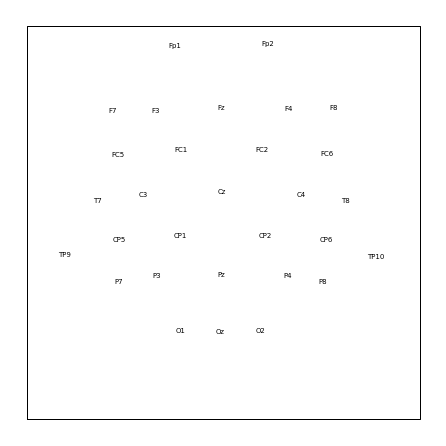

In [41]:
electrodes = mne.channels.make_eeg_layout(raw.info, radius=0.5, width=None, height=None, csd=False)

electrodes.plot() # dunno why two plots?

# View raw channels
Showing the first 100 sec of recognition phase

In [ ]:
mne.viz.plot_raw(raw, n_channels = 32, scalings = dict(eeg = 1e-4), start = 300, duration = 100); 
# I zoom in the data with "start" and "duration"

# Filtering

In [ ]:
# high-pass filtering the data at 0.1 Hz and subsequently low-pass filtering at 40 Hz
raw = raw.filter(0.1, None)
raw = raw.filter(None, 40)

# plotting the filtered data for inspection
#raw.plot(n_channels = 30, start = 0, duration = 20);

mne.viz.plot_raw(raw, n_channels = 32, scalings = dict(eeg = 1e-4), start = 300, duration = 100);

# Artefact removal
There are many ways to detect and deal with artefacts. Today, we simply select a value and reject anything above or below that value. We do this because we determine that values over or under this threshold are liekly not related to brain activity. For now, we just create the variable and then we use it to remove artefacts while epoching.

In [ ]:
# rejecting everything over or under a threshold of 150 microvolts
# anything above or belove this threshold is likely not brain activity but artefacts
reject = dict(eeg=150e-6)

# plotting the data for inspection
#raw.plot(n_channels = 30, );

mne.viz.plot_raw(raw, n_channels = 32, scalings = dict(eeg = 1e-4), start = 300, duration = 100);

# Epoching

### Anotating triggers

In [ ]:
triggers, triggers_list = mne.events_from_annotations(raw)

In [ ]:
# read in trig_list - triggers from logfile
trig_list = np.genfromtxt('trig_list.csv', delimiter=',')

In [ ]:
# number of triggers in that list
print(np.shape(trig_list))
# aligning first 10 triggers of both structures
[triggers[0:10,2], trig_list[0:10]]

In [ ]:
# making a copy of our trig_list (except 1st nan-trigger) and setting trigger-99 to 6 in order to be able to compare 
# the training-set-triggers directly with our EEG-triggers
trig_list_temp = trig_list[1:].copy()
trig_list_temp = trig_list_temp.astype(int)
trig_list_temp[trig_list_temp==99] = 6
# also a copy of the 3rd column of the triggers-structure (except 1st 99999-trigger)
triggers_temp = triggers[1:,2].copy()
triggers_temp = triggers_temp % 10 # % means modulo - it's an operator that allows you to get the "rest" number after having divided with a given number (here 10)
# comparing the first 10 triggers of both temp-structures
(triggers_temp[0:10], trig_list_temp[0:10])

In [ ]:
# getting the index of the first trigger that's not part of the learning phase (and we start from index 1 because or temp-structures don't include the first pseudo-trial)
learn_phase = np.argmax((triggers[1:,2]>151) | (triggers[1:,2]<112) & (triggers[1:,2]!=6))
# testing whether all triggers of the two vectors correspond from the beginning till then
all(triggers_temp[0:learn_phase]==trig_list_temp[0:learn_phase])

In [ ]:
# THIS IS THE CRUCIAL STEP in creating and adapted triggers-structure:
# the logic is that for any values AFTER the learning phase, we simply subtract the modulo-values in triggers-temp from the triggers
# (cuz the trigger-temp-values are equivalent to the "ones" from the triggers-structure), and then we add the values from the logfile
new_triggers = triggers.copy()
new_triggers[learn_phase+1:,2] = new_triggers[learn_phase+1:,2]-triggers_temp[learn_phase:]+trig_list_temp[learn_phase:]

In [ ]:
new_triggers[:,2] # just having a quick look at the "new" trigger-values

In [ ]:
# THIS IS WHERE WE RECODE THE TRIGGERS
# Now we want to be able to tell all the different incorrect sequences from each other
# And we know that they ALL uniquely start with 162 (cuz that's always the first number in an incrorrect sequence)
# And we also know that if the second trigger is 175 and third is not 189, then it's a sequence that is incorrect from its third place onwards (and then we add 50 to all triggers in those sequences)
# Same logic if the second and third triggers are 175 and 189, resp., and fourth is not 197, then it's a sequence that it's incorrect from its fourth place onwards (we add 100 to those)
# Same logic if the second to fourth triggers are 175, 189, 197 resp., and fifth is not 201, then it's a sequence that it's incorrect from its fifth place onwards (we add 150 to those)
incorr_idx = new_triggers[:,2] == 162 # getting a boolean index
incorr_rows = [i for i, x in enumerate(incorr_idx) if x] # getting the actual trial-numbers to have something to loop over
print(len(incorr_rows))
for i in incorr_rows:
    if (new_triggers[i+1,2]==175) & (new_triggers[i+2,2]!=189):
        #print('third')
        new_triggers[i:i+5,2] = new_triggers[i:i+5,2]+50
    elif (new_triggers[i+1,2]==175) & (new_triggers[i+2,2]==189) & (new_triggers[i+3,2]!=197):
        #print('fourth')
        new_triggers[i:i+5,2] = new_triggers[i:i+5,2]+100
    elif (new_triggers[i+1,2]==175) & (new_triggers[i+2,2]==189) & (new_triggers[i+3,2]==197) & (new_triggers[i+4,2]!=201):
        #print('fifth')
        new_triggers[i:i+5,2] = new_triggers[i:i+5,2]+150

In [ ]:
np.unique(new_triggers[:,2]) # checking how many unique triggers we need to create event_ids for

In [ ]:
new_event_id = {
 'Imagine': 6, # "Imagine"
 'recog_phase/corr/first/2': 12, # Number 1, recognition phase | correct
 'recog_phase/corr/second/5': 25, # Number 2, recognition phase | correct
 'recog_phase/corr/third/9': 39, # Number 3, recognition phase | correct
 'recog_phase/corr/fourth/7': 47, # Number 4, recognition phase | correct
 'recog_phase/corr/fifth/1': 51, # Number 5, recognition phase | correct
 'learn_phase/first/2': 112, # Number 1, learning phase
 'learn_phase/second/5': 125, # Number 2, learning phase
 'learn_phase/third/9': 139, # Number 3, learning phase
 'learn_phase/fourth/7': 147, # Number 4, learning phase
 'learn_phase/fifth/1': 151, # Number 5, learning phase
 'recog_phase/incorr2/first/2': 162, # Number 1, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/1': 171, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/3': 173, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/4': 174, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/6': 176, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/7': 177, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/8': 178, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/9': 179, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/1': 181, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/3': 183, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/4': 184, # Number 3, recognition phase | incorrect in place 2 
 'recog_phase/incorr2/third/5': 185, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/6': 186, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/7': 187, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/8': 188, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/9': 189, # Number 3, recognition phase | incorrect in place 2 
 'recog_phase/incorr2/fourth/1': 191, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/3': 193, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/5': 195, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/6': 196, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/7': 197, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/8': 198, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/9': 199, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/1': 201, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/3': 203, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/4': 204, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/5': 205, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/6': 206, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/7': 207, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/8': 208, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/9': 209, # Number 5, recognition phase | incorrect in place 2

 'recog_phase/incorr3/first/2': 212, # Number 1, recognition phase | incorrect in place 3
 'recog_phase/incorr3/second/5': 225, # Number 2, recognition phase | incorrect in place 3
 'recog_phase/incorr3/third/1': 231, # Number 3, recognition phase | incorrect in place 3
 'recog_phase/incorr3/third/4': 234, # Number 3, recognition phase | incorrect in place 3
 'recog_phase/incorr3/third/6': 236, # Number 3, recognition phase | incorrect in place 3
 'recog_phase/incorr3/fourth/7': 247, # Number 4, recognition phase | incorrect in place 3
 'recog_phase/incorr3/fourth/8': 248, # Number 4, recognition phase | incorrect in place 3
 'recog_phase/incorr3/fifth/3': 253, # Number 5, recognition phase | incorrect in place 3
 'recog_phase/incorr3/fifth/9': 259, # Number 5, recognition phase | incorrect in place 3
 
 'recog_phase/incorr4/first/2': 262, # Number 1, recognition phase | incorrect in place 4
 'recog_phase/incorr4/second/5': 275, # Number 2, recognition phase | incorrect in place 4
 'recog_phase/incorr4/third/9': 289, # Number 3, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/0': 290, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/1': 291, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/3': 293, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/4': 294, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/6': 296, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/8': 298, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/1': 301, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/3': 303, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/4': 304, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/6': 306, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/7': 307, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/8': 308, # Number 5, recognition phase | incorrect in place 4
 
 'recog_phase/incorr5/first/2': 312, # Number 1, recognition phase | incorrect in place 5
 'recog_phase/incorr5/second/5': 325, # Number 2, recognition phase | incorrect in place 5
 'recog_phase/incorr5/third/9': 339, # Number 3, recognition phase | incorrect in place 5
 'recog_phase/incorr5/fourth/7': 347, # Number 4, recognition phase | incorrect in place 5
 'recog_phase/incorr5/fifth/3': 353, # Number 5, recognition phase | incorrect in place 5
 'recog_phase/incorr5/fifth/4': 354, # Number 5, recognition phase | incorrect in place 5
 'recog_phase/incorr5/fifth/6': 356, # Number 5, recognition phase | incorrect in place 5
 }


new_event_id = {
 'Imagine': 6, # "Imagine"
 'recog_phase/corr/first/2': 12, # Number 1, recognition phase | correct
 'recog_phase/corr/second/5': 25, # Number 2, recognition phase | correct
 'recog_phase/corr/third/9': 39, # Number 3, recognition phase | correct
 'recog_phase/corr/fourth/7': 47, # Number 4, recognition phase | correct
 'recog_phase/corr/fifth/1': 51, # Number 5, recognition phase | correct
 'learn_phase/first/2': 112, # Number 1, learning phase
 'learn_phase/second/5': 125, # Number 2, learning phase
 'learn_phase/third/9': 139, # Number 3, learning phase
 'learn_phase/fourth/7': 147, # Number 4, learning phase
 'learn_phase/fifth/1': 151, # Number 5, learning phase
 'recog_phase/incorr2/first/2': 162, # Number 1, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/1': 171, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/3': 173, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/4': 174, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/6': 176, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/7': 177, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/8': 178, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/9': 179, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/1': 181, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/3': 183, # Number 3, recognition phase | incorrect in place 2
# fill in    ...
 'recog_phase/incorr3/first/2': 212, # Number 1, recognition phase | incorrect in place 3
 'recog_phase/incorr3/second/5': 225, # Number 2, recognition phase | incorrect in place 3
 'recog_phase/incorr3/third/1': 231, # Number 3, recognition phase | incorrect in place 3
 'recog_phase/incorr3/third/4': 234, # Number 3, recognition phase | incorrect in place 3
# fill in    ...
 'recog_phase/incorr4/first/2': 262, # Number 1, recognition phase | incorrect in place 4
 'recog_phase/incorr4/second/5': 275, # Number 2, recognition phase | incorrect in place 4
 'recog_phase/incorr4/third/9': 289, # Number 3, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/0': 290, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/1': 291, # Number 4, recognition phase | incorrect in place 4
# fill in    ...
 'recog_phase/incorr5/first/2': 312, # Number 1, recognition phase | incorrect in place 5
 'recog_phase/incorr4/second/5': 325, # Number 2, recognition phase | incorrect in place 5
 'recog_phase/incorr4/third/9': 339, # Number 3, recognition phase | incorrect in place 5
 'recog_phase/incorr4/fourth/7': 347, # Number 4, recognition phase | incorrect in place 5
 'recog_phase/incorr4/fifth/3': 353, # Number 5, recognition phase | incorrect in place 5
 'recog_phase/incorr4/fifth/4': 354, # Number 5, recognition phase | incorrect in place 5
 'recog_phase/incorr4/fifth/6': 356, # Number 5, recognition phase | incorrect in place 5
 }

</opt/conda/lib/python3.7/site-packages/decorator.py:decorator-gen-282>:12: RuntimeWarning: event 99999 missing from event_id will be ignored
</opt/conda/lib/python3.7/site-packages/decorator.py:decorator-gen-282>:12: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.


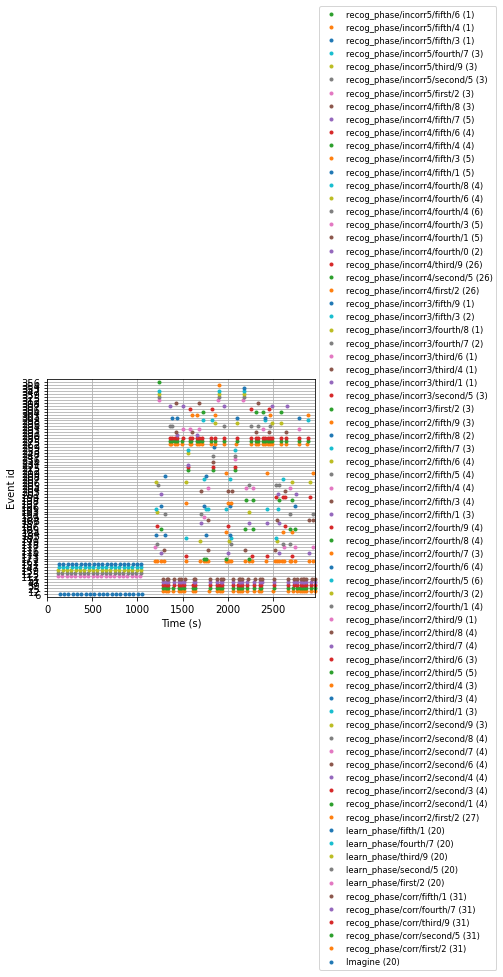

In [26]:
# plotting the events
mne.viz.plot_events(new_triggers[:,:], sfreq=250, first_samp=raw.first_samp, event_id=new_event_id);

### Establishing a time window to show epochs within
The time window we establish span from 0.2 seconds before stimulus onset to 0.5 seconds after stimulus onset. The 200 milliseconds before the onset of the stimulus enables us to examine a baseline of activity without stimulus presentation. The 500 milliseconds after the stimulus onset denote the time in which we expect the effect to occur, since most EEG components arise before the 500 milliseconds mark.

In [27]:
# establishing time window
tmin, tmax = -0.2, 0.5

# choosing only EEG channels for epoching
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False)

In [28]:
# creating the epochs using the variables created in the cell above, and timelocking to the events
# baseline time interval spans from beginning of the data (-0.2 s) to 0 s (stimulus onset)
# we use the reject variable we created earlier in order to remove artefacts
epochs = mne.Epochs(raw, new_triggers[:,:], new_event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=reject, preload=True)

Not setting metadata
570 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 570 events and 701 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'F8', 'FC5', 'FC1', 'FC6', 'T7', 'CP5', 'Oz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'F8', 'FC5', 'FC6', 'C4']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting

# Downsampling

In [29]:
# downsampling to 250 Hz
epochs_resampled = epochs.resample(250)

In [34]:
# Exporting epocs
epochs_resampled.save('ownExperiment_epochs-epo.fif')

# Event Related Potentials (ERP)
Now we can group the epochs by modality (auditory/visual) and take a look at the differences between them!

Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


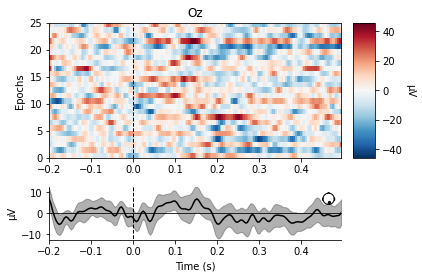

Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


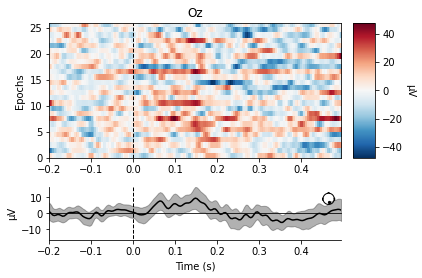

Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


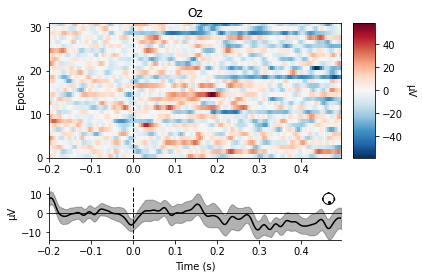

In [37]:
# now the '/' used in the event IDs comes in handy! To get all epochs with auditory stimuli, we can index 'auditory' across the left/right dimension (and 'visual', of course)
# that way we don't have to specify 'auditory_left' and 'auditory_right' etc.
second_incorr = epochs_resampled['recog_phase/incorr2/second'] # when number broke sequence in 2nd position
fourth_incorr = epochs_resampled['recog_phase/incorr4/fourth'] # when number broke sequence in 4th position

fifth_corr = epochs_resampled['recog_phase/corr/fifth'] # number five during learning phase


# plotting one channel as an example for each modality
second_incorr.plot_image(picks=['Oz']);
fourth_incorr.plot_image(picks=['Oz']);

fifth_corr.plot_image(picks=['Oz']);

In [38]:
# creating evokeds for auditory condition by averaging over epochs
second_epocs = second_incorr.average()

# creating evokeds for visual condition
fourth_epocs = fourth_incorr.average()

# creating evokeds for correct phase for fifth number (= hopefully we see no reaction compared to the others)
corr_epocs_fifth = fifth_corr.average()

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


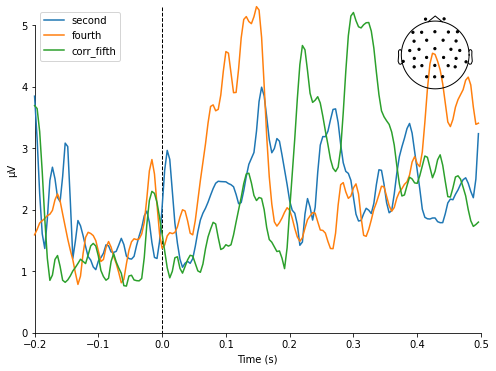

[<Figure size 576x432 with 2 Axes>]

In [39]:
# plotting the two evokeds together
mne.viz.plot_compare_evokeds(dict(second=second_epocs, fourth=fourth_epocs, corr_fifth=corr_epocs_fifth),
                             legend='upper left', show_sensors='upper right')

No projector specified for this dataset. Please consider the method self.add_proj.


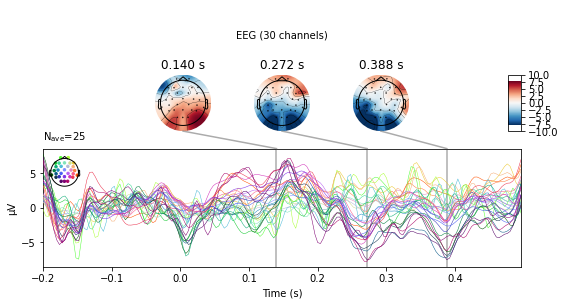

No projector specified for this dataset. Please consider the method self.add_proj.


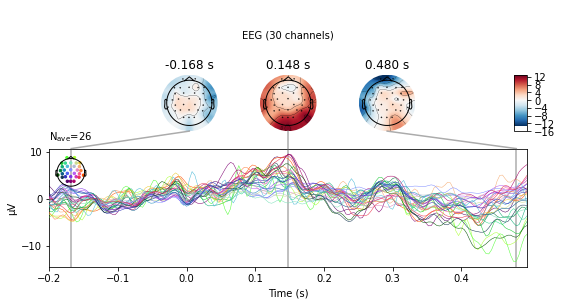

In [33]:
second_epocs.plot_joint(picks='eeg');
fourth_epocs.plot_joint(picks='eeg');

# Independent component analysis (ICA)
ICA can be used for artefact detection, since it identifies seperate components of the signal that have been combined during recording. That means that we can actually separate noise compoenents, such as eye blinks, from the rest of the signal, and thereby exclude them.

In [ ]:
# set up and fit the ica with 800 iterations with a random seed at 97
# n_components=0.95 ensures that the number of components selected explain at least 95% of the variance in the data
ica = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800)
ica.fit(raw)

In [ ]:
# plotting the ica components
ica.plot_components();

In [ ]:
# plotting the time series of the ica
ica.plot_sources(raw, show_scrollbars=False);

From visual inspection of the topographic maps and the time series plots of the components, we can see that the first and fifth component seems to capture noise. Consequently, we can remove them and thereby extract these artefacts from the data.

In [ ]:
# the first component is excluded based on visual inspection
ica.exclude = [0,4]
ica.plot_properties(raw, picks=ica.exclude);

We can now apply the ICA to the data.

In [ ]:
# applying the ica to the data
ica.apply(raw)

In [ ]:
# plotting the data after filtering and ica
raw.plot();

Now try to run 
- artefact-detection
- epoching
- downsampling
- the single-trial plots
- the evokeds plots

(i.e. exactly like you just did in the above)

Now compare your results with and without ICA - can you tell any differences between the two, just qualitatively speaking?

In [ ]:
#FILTERING

# high-pass filtering the data at 0.1 Hz and subsequently low-pass filtering at 40 Hz
raw = raw.filter(0.1, None)
raw = raw.filter(None, 40)

# plotting the filtered data for inspection
#raw.plot(n_channels = 30, start = 0, duration = 20);

mne.viz.plot_raw(raw, n_channels = 32, scalings = dict(eeg = 1e-4), start = 300, duration = 100);

In [ ]:
# ARTEFACT REMOVAL

# rejecting everything over or under a threshold of 150 microvolts
# anything above or belove this threshold is likely not brain activity but artefacts
reject = dict(eeg=150e-6)

# plotting the data for inspection
#raw.plot(n_channels = 30, );

mne.viz.plot_raw(raw, n_channels = 32, scalings = dict(eeg = 1e-4), start = 319, duration = 100);

In [ ]:
# creating the epochs using the variables created in the cell above, and timelocking to the events
# baseline time interval spans from beginning of the data (-0.2 s) to 0 s (stimulus onset)
# we use the reject variable we created earlier in order to remove artefacts
epochs = mne.Epochs(raw, new_triggers[:,:], new_event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=reject, preload=True)

In [ ]:
# downsampling to 250 Hz
epochs_resampled = epochs.resample(250)

In [ ]:
# now the '/' used in the event IDs comes in handy! To get all epochs with auditory stimuli, we can index 'auditory' across the left/right dimension (and 'visual', of course)
# that way we don't have to specify 'auditory_left' and 'auditory_right' etc.
second_incorr = epochs_resampled['recog_phase/incorr2/second'] # when number broke sequence in 2nd position
fourth_incorr = epochs_resampled['recog_phase/incorr4/fourth'] # when number broke sequence in 4th position

learn = epochs_resampled['learn_phase/fifth'] # number five during learning phase


# plotting one channel as an example for each modality
second_incorr.plot_image(picks=['Oz']);
fourth_incorr.plot_image(picks=['Oz']);

learn.plot_image(picks=['Oz']);

In [ ]:
# creating evokeds for auditory condition by averaging over epochs
second_epocs = second_incorr.average()

# creating evokeds for visual condition
fourth_epocs = fourth_incorr.average()

# creating evokeds for learning phase (= hopefully we see no reaction compared to the others)
learn_epocs_fifth = learn.average()

In [ ]:
# plotting the two evokeds together
mne.viz.plot_compare_evokeds(dict(second=second_epocs, fourth=fourth_epocs, learn=learn_epocs_fifth),
                             legend='upper left', show_sensors='upper right')